# QuakeMigrate example - Icequake detection in Iceland

## Overview

This notebook shows how to run QuakeMigrate for icequake detection, using a 2 minute window of continuous seismic data from Hudson et al. (2019). Please refer to this paper for details and justification of the settings used.

Here, we detail how to:
1. Create travel-time lookup tables for the example seismometer network
2. Run the detect stage to coalesce energy through time
3. Run the trigger stage to determine events above a threshold value
4. Run the locate stage to refine the earthquake location

In [1]:
from pyproj import Proj

import pandas as pd

from QMigrate.io import Archive
from QMigrate.io import stations as read_stations
from QMigrate.lut import compute, LUT
from QMigrate.signal import QuakeScan, Trigger
from QMigrate.signal.onset import STALTAOnset
from QMigrate.signal.pick import GaussianPicker

%matplotlib inline

In [2]:
# --- i/o paths ---
station_file = "./inputs/iceland_stations.txt"
data_in = "./inputs/mSEED"
lut_out = "./outputs/lut/icequake.LUT"
run_path = "./outputs/runs"
run_name = "icequake_example"

## Create travel-time lookup tables (LUT)

In [3]:
# --- Read in the station information file ---
stations = read_stations(station_file)

# --- Define projections ---
cproj = Proj(proj="longlat", ellps="WGS84", datum="WGS84", no_defs=True)
gproj = Proj(proj="lcc", lon_0=-17.224, lat_0=64.328, lat_1=64.32, lat_2=64.335,
             datum="WGS84", ellps="WGS84", units="m", no_defs=True)

# --- Create new LUT ---
# Cell count (x,y,z); cell size (x,y,z in metres)
lut = LUT(ll_corner=[-17.24363934275664, 64.31947715407385, -1390.],
          ur_corner=[-17.204348515198255, 64.3365202025144, 1390],
          cell_size=[50., 50., 20.], grid_proj=gproj, coord_proj=cproj)

# --- Homogeneous LUT generation ---
vp = 3630
vs = 1833
compute(lut, stations, method="homogeneous", vp=vp, vs=vs)

# --- Save LUT ---
lut.save(lut_out)

Computing homogeneous traveltime lookup table - 1 of 13
Computing homogeneous traveltime lookup table - 2 of 13
Computing homogeneous traveltime lookup table - 3 of 13
Computing homogeneous traveltime lookup table - 4 of 13
Computing homogeneous traveltime lookup table - 5 of 13
Computing homogeneous traveltime lookup table - 6 of 13
Computing homogeneous traveltime lookup table - 7 of 13
Computing homogeneous traveltime lookup table - 8 of 13
Computing homogeneous traveltime lookup table - 9 of 13
Computing homogeneous traveltime lookup table - 10 of 13
Computing homogeneous traveltime lookup table - 11 of 13
Computing homogeneous traveltime lookup table - 12 of 13
Computing homogeneous traveltime lookup table - 13 of 13


## Coalesce the seismic energy through time

In [4]:
# --- Read in station file ---
stations = read_stations(station_file)

# --- Create new Archive and set path structure ---
archive = Archive(stations=stations, archive_path=data_in)
archive.path_structure(archive_format="YEAR/JD/*_STATION_*")

# --- Create new Onset ---
onset = STALTAOnset(position="classic")
onset.p_bp_filter = [10, 125, 4]
onset.s_bp_filter = [10, 125, 4]
onset.p_onset_win = [0.01, 0.25]
onset.s_onset_win = [0.05, 0.5]

# --- Create new QuakeScan ---
scan = QuakeScan(archive, lut, onset=onset, run_path=run_path, run_name=run_name)

# --- Set detect parameters ---
scan.sampling_rate = 500
scan.timestep = 0.75
scan.threads = 12

# --- Set time period over which to run detect ---
starttime = "2014-06-29T18:41:55.0"
endtime = "2014-06-29T18:42:20.0"

In [5]:
# --- Run detect ---
scan.detect(starttime, endtime)

	QuakeMigrate RUN - Path: outputs/runs/icequake_example - Name: icequake_example

	DETECT - Continuous coalescence scan

	Scanning from 2014-06-29T18:41:55.000000Z to 2014-06-29T18:42:20.000000Z

	Scan parameters:
		Data sampling rate = 500 Hz
		Time step = 0.75 s
		Marginal window = 2.0 s
		Thread count = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 500 Hz

		Bandpass filter P  = [10, 125, 4] (Hz, Hz, -)
		Bandpass filter S  = [10, 125, 4] (Hz, Hz, -)

		Onset P [STA, LTA] = [0.01, 0.25] (s, s)
		Onset S [STA, LTA] = [0.05, 0.5] (s, s)

~~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:53.350000Z-2014-06-29T18:42:00.750000Z ~~~~~~~~~~~~~~~~~~~~
                     Elapsed time: 1.000469 seconds.
~~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:54.100000Z-2014-06-29T18:42:01.500000Z ~~~~~~~~~~~~~~~~~~~~
                     Elapsed time: 0.801032 seconds.
~~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:54.850000Z-2014-06-29T18:42:02.250000Z ~~~~

## Run the trigger stage, to detect and output individual icequakes

nb: We can use the same QuakeScan object here because we are not using a different decimation. If running trigger and locate on grids with different levels of decimation, a new QuakeScan object should be created.

	QuakeMigrate RUN - Path: outputs/runs/icequake_example - Name: icequake_example

	TRIGGER - Triggering events from coalescence

	Triggering events from 2014-06-29T18:41:55.000000Z to 2014-06-29T18:42:20.000000Z

	Trigger parameters:
		Pre/post pad = 120.0 s
		Marginal window = 1.0 s
		Minimum repeat  = 6.0 s

		Triggering from normalised coalescence stream.

		Detection threshold method: static
		Static threshold = 1.8

	Reading in .scanmseed...
	    Warning!
	    No .scanmseed data found for pre-pad!
	    Warning!
	    No .scanmseed data found for post-pad!
	...from 2014-06-29T18:41:55.000000Z - 2014-06-29T18:42:20.498000Z.
	.scanmseed read complete.

	Triggering events...
	    Triggered event 1 of 1
	Writing triggered events to file...

	Plotting trigger summary...
	Reading in .StationAvailability...
	...from 2014-06-29T18:41:55.000000Z - 2014-06-29T18:42:19.750000Z
	.StationAvailability read complete.


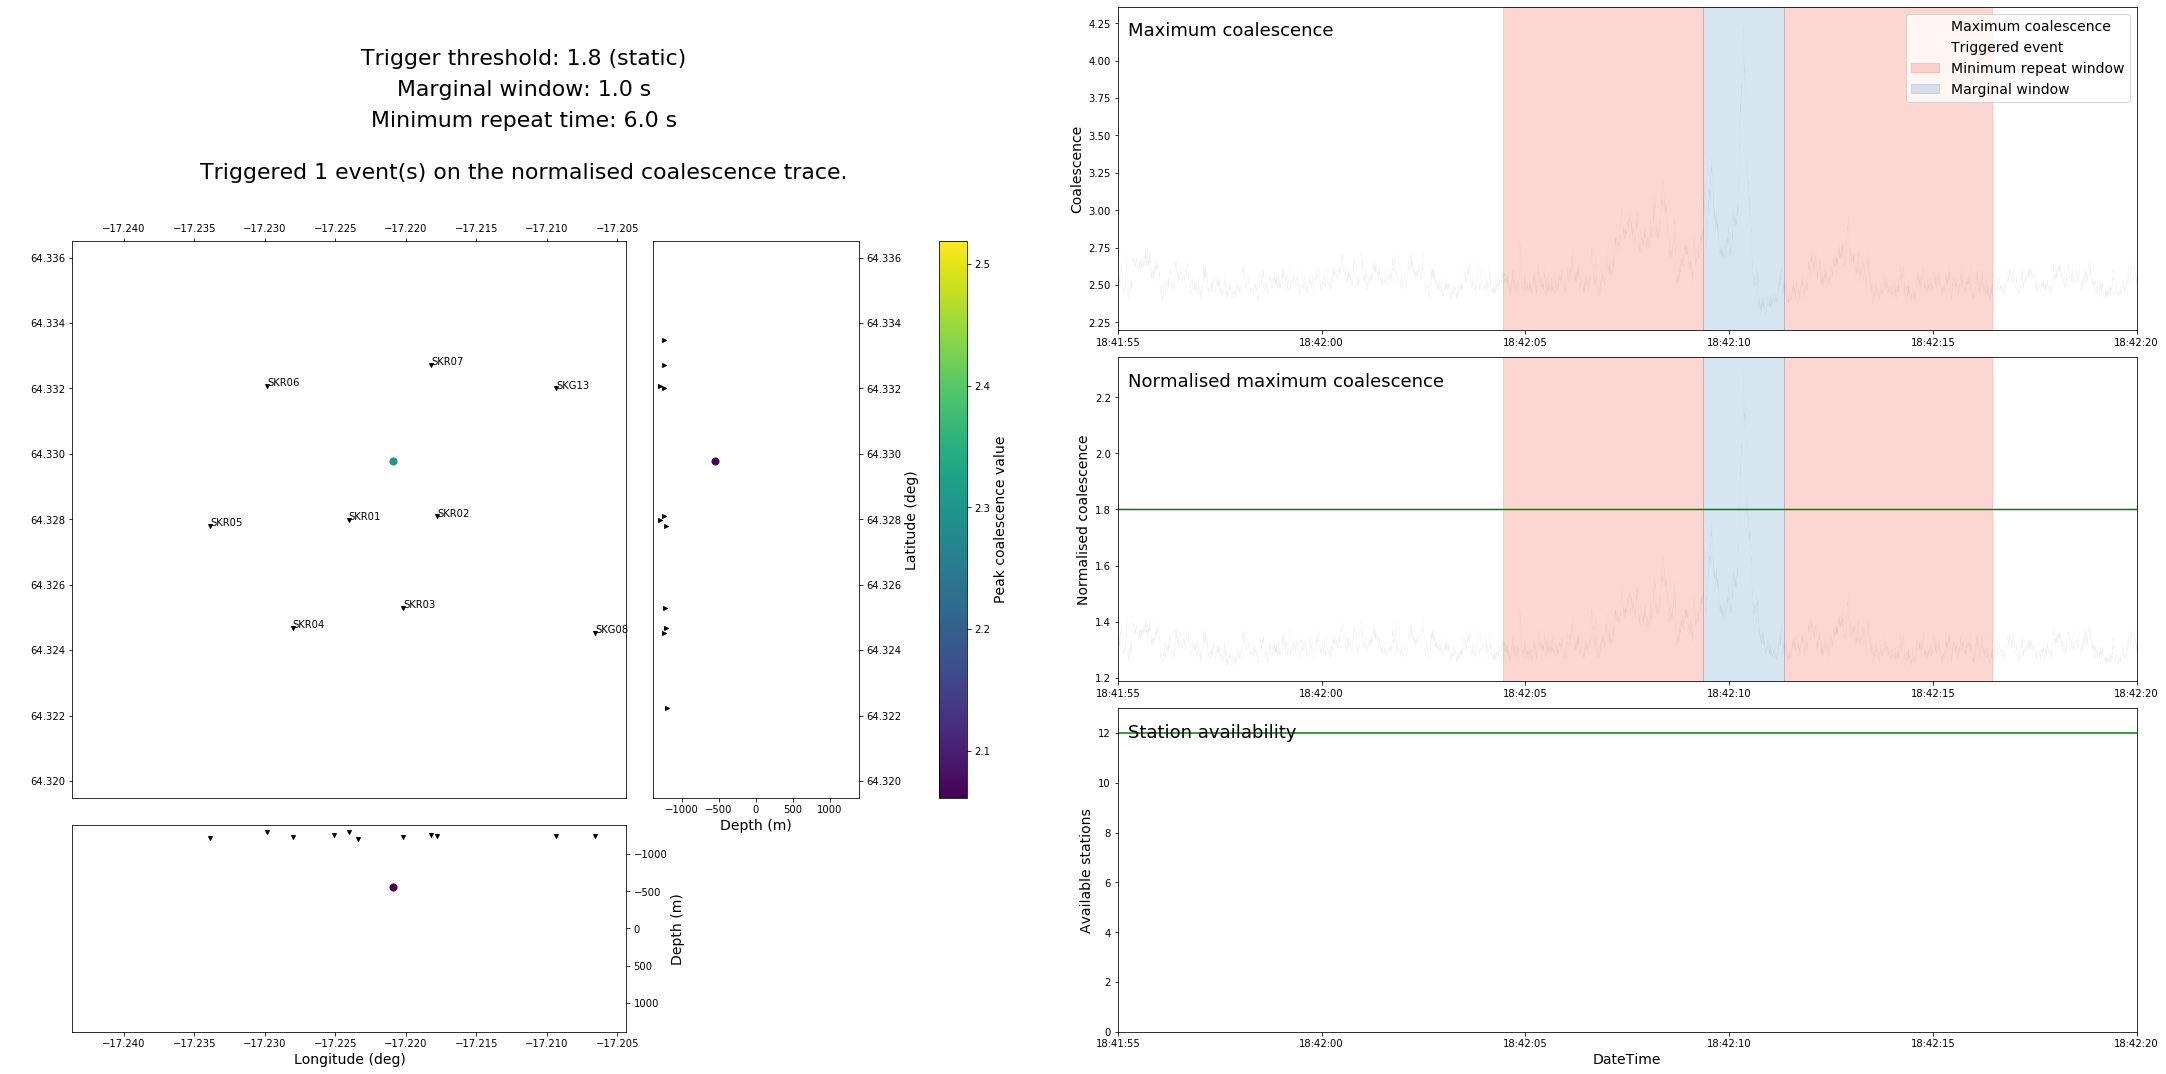

In [14]:
# --- Create new Trigger ---
trig = Trigger(lut, run_path=run_path, run_name=run_name)

# --- Set trigger parameters ---
trig.marginal_window = 1.
trig.minimum_repeat = 6.
trig.normalise_coalescence = True

# --- Static threshold ---
trig.threshold_method = "static"
trig.static_threshold = 1.8

# --- Run trigger ---
trig.trigger(starttime, endtime, savefig=True)

## Run the locate stage, to relocate triggered events on a less decimated grid

In [20]:
# --- Create new PhasePicker ---
picker = GaussianPicker(onset=onset)
picker.marginal_window = 2.75
picker.plot_picks = True

# --- Create new QuakeScan ---
scan = QuakeScan(archive, lut, onset=onset, picker=picker,
                 run_path=run_path, run_name=run_name)

# --- Set locate parameters ---
scan.marginal_window = 1.
scan.threads = 12
scan.sampling_rate = 500

# --- Toggle plotting options ---
scan.plot_event_summary = True
scan.plot_event_video = False

# --- Toggle writing of waveforms ---
scan.write_cut_waveforms = False

In [21]:
# --- Run locate ---
scan.locate(starttime=starttime, endtime=endtime)

	QuakeMigrate RUN - Path: outputs/runs/icequake_example - Name: icequake_example

	LOCATE - Determining event location and uncertainty

	Locating events from 2014-06-29T18:41:55.000000Z to 2014-06-29T18:42:20.000000Z

	Scan parameters:
		Data sampling rate = 500 Hz
		Time step = 120.0 s
		Marginal window = 1.0 s
		Thread count = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 500 Hz

		Bandpass filter P  = [10, 125, 4] (Hz, Hz, -)
		Bandpass filter S  = [10, 125, 4] (Hz, Hz, -)

		Onset P [STA, LTA] = [0.01, 0.25] (s, s)
		Onset S [STA, LTA] = [0.05, 0.5] (s, s)

	Phase picking by fitting a 1-D Gaussian to onsets
		Pick threshold  = 1.0
		Marginal window = 2.75 s
		Search window   = 10.0% of travel-time


	EVENT - 1 of 1 - 20140629184210348
	Determining event location...
	Reading waveform data...
                     Elapsed time: 0.118000 seconds.
	Computing 4-D coalescence function...
                     Elapsed time: 4.805971 seconds.
	Determining eve

## Some of the key outputs

In [17]:
# Show the .event file, containing event origin time and location:
icequake_event_fname = "./outputs/runs/icequake_example/locate/events/20140629184210348.event"
event_df = pd.read_csv(icequake_event_fname)

event_df

,DT,COA,COA_NORM,X,Y,Z,LocalGaussian_X,LocalGaussian_Y,LocalGaussian_Z,LocalGaussian_ErrX,...,GlobalCovariance_Y,GlobalCovariance_Z,GlobalCovariance_ErrX,GlobalCovariance_ErrY,GlobalCovariance_ErrZ,TRIG_COA,DEC_COA,DEC_COA_NORM,ML,ML_Err
0,2014-06-29T18:42:10.348000Z,4.262224,2.290079,-17.225241,64.330108,-1286.0,-17.224909,64.329072,-1256.290971,332.080851,...,64.328004,-14.823519,561.870203,561.917988,809.268553,2.29008,4.26222,2.29008,NaN,NaN


In [18]:
# Show the .picks file, containing station time picks:
icequake_pick_fname = "outputs/runs/icequake_example/locate/picks/20140629184210348.picks"
pick_df = pd.read_csv(icequake_pick_fname)

pick_df

,Station,Phase,ModelledTime,PickTime,PickError,SNR
0,SKR01,P,2014-06-29T18:42:10.564740Z,2014-06-29T18:42:10.537219Z,0.008249,17.115957
1,SKR01,S,2014-06-29T18:42:10.777223Z,2014-06-29T18:42:10.760749Z,0.050606,8.248138
2,SKR02,P,2014-06-29T18:42:10.550495Z,2014-06-29T18:42:10.546191Z,0.007972,14.103288
3,SKR02,S,2014-06-29T18:42:10.749013Z,-1,-1.000000,-1.000000
4,SKR03,P,2014-06-29T18:42:10.581275Z,2014-06-29T18:42:10.584064Z,0.008631,8.777560
5,SKR03,S,2014-06-29T18:42:10.809969Z,2014-06-29T18:42:10.838773Z,0.045679,7.051575
6,SKR04,P,2014-06-29T18:42:10.608702Z,-1,-1.000000,-1.000000
7,SKR04,S,2014-06-29T18:42:10.864284Z,2014-06-29T18:42:10.906280Z,0.017805,5.114602
8,SKR05,P,2014-06-29T18:42:10.608435Z,2014-06-29T18:42:10.599337Z,0.005859,14.517596
9,SKR05,S,2014-06-29T18:42:10.863755Z,2014-06-29T18:42:10.897230Z,0.040495,8.004376


In [22]:
# Show the coalescence pdf file, containing event origin time and location:
icequake_coal_image_fname = "outputs/runs/icequake_example/locate/summaries/icequake_example_20140629184210348_EventSummary.pdf"
from IPython.display import IFrame # For plotting pdf
IFrame(icequake_coal_image_fname, width=800, height=400) # Plot pdf

References:

Hudson, T.S., Smith, J., Brisbourne, A.M., and White R.S. (2019). Automated detection of basal icequakes and discrimination from surface crevassing. Annals of Glaciology, 79